## Clustering on Chocolate Bar Ratings

#### Author: Andrew Tran

## Blog Post Inspiration and Objectives

In this blog post, I am exploring basic methods of clustering in Machine Learning. One interesting topic that I came across included a dataset thousands of different types of chocolate bars found across the world globally, including all other documented factors such as the Company that made it, the origin of the cocoa bean used in it, the year of the chocolate bar review, the percentage of cocoa computed in the composition of the bar, etc. I thought that it would be interesting to see if I can determine if I can figure out any corrleation relationships between the features of the chocolate bar and its numerical rating through means of clustering. My logic is that similar-featured chocolate bars would be grouped in the same cluster. However, this may lead to concerns in determining which factors (if any) weigh more in terms of swaying the rating of that particular chocolate bar entry. Thus, I soon began my blog post, trying to find some way to resolve this question. With that said, let's try to analyze this topic with some Machine Learning:

## Data Preprocessing - Cleaning and Analytics

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
import seaborn as sns
color = sns.color_palette()
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import kneed
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, pairwise_distances
plt.style.use("fivethirtyeight")

First, we will read and display the initial dataset in our file system for this blog post, downloaded from Kaggle. This dataset contains loads of valuable information such as all notable chocolate-bar quantiative statistics that you would typically document such as Company that created the bar being reviewed, REF number, Year of Review Date, Cocoa Percent in bar, Company Location of the bar being reviewed, Bean Type, and Cocoa Bean origin of the company that distributed the bar being reviewed.

In [2]:
# Reading and displaying the initial dataset (ignoring any warnings or errors)
df = pd.read_csv("datasets/flavors_of_cacao.csv")
df

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


For clarity on the constraints and parameters of the working datasets, I went to find high-level exploratory statistics on all of the datasets: shape, information about all of the entries, etc.

In [3]:
# Determining the shape of the initial dataset
df.shape

(1795, 9)

In [4]:
# Getting a sample of the initial dataset through the seeing the first 10 entries
# completely in the dataset
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [5]:
# Figuring out all of the columns (and their names) available for me to use in 
# the dataset
df.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

In [6]:
# Getting basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company 
(Maker-if known)         1795 non-null   object 
 1   Specific Bean Origin
or Bar Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review
Date                       1795 non-null   int64  
 4   Cocoa
Percent                     1795 non-null   object 
 5   Company
Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean
Type                         1794 non-null   object 
 8   Broad Bean
Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [7]:
# Figuring out the number of duplicated elements in the dataset (could be 
# problematic if not resolved)
df.duplicated().sum()

0

Additionally, before handing my Financial-Institution Fraud dataset over for Machine Learning training and prediction, I need to clean the data prior to the analysis stage: removing duplicates, deleting null/NaN values, fixing types of columns, filling invalid values with suitable alternatives, etc.

In [8]:
# Renaming the columns to be more readable 
cols_rename_dict = {}
for col in df.columns:
    cols_rename_dict.update({col: col.replace("\n", " ")})
df = df.rename(columns=cols_rename_dict)

df.rename(columns={"REF": "Reference Number"}, inplace=True)

cols_rename_dict = {}
for col in df.columns:
    cols_rename_dict.update({col: col.replace(" (Maker-if known)", "")})
df = df.rename(columns=cols_rename_dict)
df.columns = df.columns.str.strip()

df

,Company,Specific Bean Origin or Bar Name,Reference Number,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


In [9]:
# Figuring out the number of 'null'/'NaN' elements in the dataset (i.e. if NaN 
# filling is needed or not)
print(df.isnull().sum())
(df.isnull().sum() / df.shape[0]) * 100

Company                             0
Specific Bean Origin or Bar Name    0
Reference Number                    0
Review Date                         0
Cocoa Percent                       0
Company Location                    0
Rating                              0
Bean Type                           1
Broad Bean Origin                   1
dtype: int64


Company                             0.00000
Specific Bean Origin or Bar Name    0.00000
Reference Number                    0.00000
Review Date                         0.00000
Cocoa Percent                       0.00000
Company Location                    0.00000
Rating                              0.00000
Bean Type                           0.05571
Broad Bean Origin                   0.05571
dtype: float64

In [10]:
for col in df.columns:
    display(df[col].unique())

array(['A. Morin', 'Acalli', 'Adi', 'Aequare (Gianduja)', 'Ah Cacao',
       "Akesson's (Pralus)", 'Alain Ducasse', 'Alexandre',
       'Altus aka Cao Artisan', 'Amano', 'Amatller (Simon Coll)',
       'Amazona', 'Ambrosia', 'Amedei', 'AMMA', 'Anahata', 'Animas',
       'Ara', 'Arete', 'Artisan du Chocolat',
       'Artisan du Chocolat (Casa Luker)', 'Askinosie', 'Bahen & Co.',
       'Bakau', 'Bar Au Chocolat', "Baravelli's", 'Batch', 'Beau Cacao',
       'Beehive', 'Belcolade', 'Bellflower', 'Belyzium', 'Benoit Nihant',
       'Bernachon', 'Beschle (Felchlin)', 'Bisou', 'Bittersweet Origins',
       'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
       'Blue Bandana', 'Bonnat', 'Bouga Cacao (Tulicorp)', 'Bowler Man',
       "Brasstown aka It's Chocolate", 'Brazen', 'Breeze Mill', 'Bright',
       'Britarev', 'Bronx Grrl Chocolate', 'Burnt Fork Bend',
       'Cacao Arabuco', 'Cacao Atlanta', 'Cacao Barry', 'Cacao de Origen',
       'Cacao de Origin', 'Cacao Hunters', 'Cacao M

array(['Agua Grande', 'Kpime', 'Atsane', ..., 'Indianer, Raw',
       'Kerala State', 'Brazil, Mitzi Blue'], dtype=object)

array([1876, 1676, 1680, 1704, 1315, 1319, 1011, 1015, 1019,  797, 1462,
       1470,  705,  370,  316,  636,  502,  508, 1215, 1061, 1173, 1944,
       1728, 1732, 1125, 1129, 1133,  725,  470,  544,  363,  304,  129,
        147,  175,  322,  327,  464, 1145, 1494, 1498,  979,  111,  123,
        170,   40,   75, 1065,  572, 1259, 1852, 1375, 1379, 1724, 1900,
       1904, 1908, 1924, 1928, 1534, 1598, 1602, 1193,  947,  729,  745,
        486,  531,  600,  355,  300, 1181, 1780,  647,  661,  331,  141,
       1474,  995,  999, 1454, 1554, 1295,  983,  955, 1840, 1868, 1880,
       1948, 1784, 1788,  586, 1800, 1804, 1864, 1768, 1141,  757,  773,
       1482, 1486,  963,  478,  558,  565,  414,  423,  431,  233,  256,
       1331, 1046, 1740, 1752, 1756,  911, 1912, 1339, 1418, 1038, 1042,
        629,  672,  761,  336,  395,  199,   24,   32,   48,   81,  341,
       1267, 1271, 1255, 1355, 1514, 1518, 1149, 1231, 1235, 1638, 1299,
       1303, 1323, 1606, 1716, 1688, 1692, 1391, 13

array([2016, 2015, 2014, 2013, 2012, 2011, 2009, 2010, 2017, 2008, 2007,
       2006], dtype=int64)

array(['63%', '70%', '60%', '80%', '88%', '72%', '55%', '75%', '65%',
       '85%', '73%', '64%', '66%', '68%', '50%', '100%', '77%', '90%',
       '71%', '83%', '78%', '74%', '76%', '86%', '82%', '69%', '91%',
       '42%', '61%', '73.5%', '62%', '67%', '58%', '60.5%', '79%', '81%',
       '57%', '72.5%', '56%', '46%', '89%', '99%', '84%', '53%', '87%'],
      dtype=object)

array(['France', 'U.S.A.', 'Fiji', 'Ecuador', 'Mexico', 'Switzerland',
       'Netherlands', 'Spain', 'Peru', 'Canada', 'Italy', 'Brazil',
       'U.K.', 'Australia', 'Wales', 'Belgium', 'Germany', 'Russia',
       'Puerto Rico', 'Venezuela', 'Colombia', 'Japan', 'New Zealand',
       'Costa Rica', 'South Korea', 'Amsterdam', 'Scotland', 'Martinique',
       'Sao Tome', 'Argentina', 'Guatemala', 'South Africa', 'Bolivia',
       'St. Lucia', 'Portugal', 'Singapore', 'Denmark', 'Vietnam',
       'Grenada', 'Israel', 'India', 'Czech Republic',
       'Domincan Republic', 'Finland', 'Madagascar', 'Philippines',
       'Sweden', 'Poland', 'Austria', 'Honduras', 'Nicaragua',
       'Lithuania', 'Niacragua', 'Chile', 'Ghana', 'Iceland', 'Eucador',
       'Hungary', 'Suriname', 'Ireland'], dtype=object)

array([3.75, 2.75, 3.  , 3.5 , 4.  , 3.25, 2.5 , 5.  , 1.75, 1.5 , 2.25,
       2.  , 1.  ])

array(['\xa0', 'Criollo', 'Trinitario', 'Forastero (Arriba)', 'Forastero',
       'Forastero (Nacional)', 'Criollo, Trinitario',
       'Criollo (Porcelana)', 'Blend', 'Trinitario (85% Criollo)',
       'Forastero (Catongo)', 'Forastero (Parazinho)',
       'Trinitario, Criollo', 'CCN51', 'Criollo (Ocumare)', 'Nacional',
       'Criollo (Ocumare 61)', 'Criollo (Ocumare 77)',
       'Criollo (Ocumare 67)', 'Criollo (Wild)', 'Beniano', 'Amazon mix',
       'Trinitario, Forastero', 'Forastero (Arriba) ASS', 'Criollo, +',
       'Amazon', 'Amazon, ICS', 'EET', 'Blend-Forastero,Criollo',
       'Trinitario (Scavina)', 'Criollo, Forastero', 'Matina',
       'Forastero(Arriba, CCN)', 'Nacional (Arriba)',
       'Forastero (Arriba) ASSS', 'Forastero, Trinitario',
       'Forastero (Amelonado)', nan, 'Trinitario, Nacional',
       'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Criollo (Amarru)'],
      dtype=object)

array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', '\xa0', 'Jamaica',
       'Grenada', 'Guatemala', 'Honduras', 'Costa Rica',
       'Domincan Republic', 'Haiti', 'Congo', 'Philippines', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Uganda',
       'Martinique', 'Sao Tome & Principe', 'Vanuatu', 'Australia',
       'Liberia', 'Ecuador, Costa Rica', 'West Africa', 'Hawaii',
       'St. Lucia', 'Cost Rica, Ven', 'Peru, Madagascar',
       'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Tobago', 'Ven., Indonesia, Ecuad.',
       'Trinidad-Tobago

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company                           1795 non-null   object 
 1   Specific Bean Origin or Bar Name  1795 non-null   object 
 2   Reference Number                  1795 non-null   int64  
 3   Review Date                       1795 non-null   int64  
 4   Cocoa Percent                     1795 non-null   object 
 5   Company Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean Type                         1794 non-null   object 
 8   Broad Bean Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [12]:
# Fill unknown and unformatted values with proper ones for readability and to
# improve data accuracy and relevance 
df["Bean Type"].fillna("N/A", inplace=True)
df["Bean Type"].replace("\xa0", "N/A", inplace=True)

df["Broad Bean Origin"].fillna("N/A", inplace=True)
df["Broad Bean Origin"].replace("\xa0", "N/A", inplace=True)

df

,Company,Specific Bean Origin or Bar Name,Reference Number,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,N/A,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,N/A,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,N/A,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,N/A,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,N/A,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,N/A,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,N/A,India


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company                           1795 non-null   object 
 1   Specific Bean Origin or Bar Name  1795 non-null   object 
 2   Reference Number                  1795 non-null   int64  
 3   Review Date                       1795 non-null   int64  
 4   Cocoa Percent                     1795 non-null   object 
 5   Company Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean Type                         1795 non-null   object 
 8   Broad Bean Origin                 1795 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [14]:
# Check to make sure if all NaN and also any unpreferred / unformatted values
# are resolved now
print(df.isnull().sum())
(df.isnull().sum() / df.shape[0]) * 100

Company                             0
Specific Bean Origin or Bar Name    0
Reference Number                    0
Review Date                         0
Cocoa Percent                       0
Company Location                    0
Rating                              0
Bean Type                           0
Broad Bean Origin                   0
dtype: int64


Company                             0.0
Specific Bean Origin or Bar Name    0.0
Reference Number                    0.0
Review Date                         0.0
Cocoa Percent                       0.0
Company Location                    0.0
Rating                              0.0
Bean Type                           0.0
Broad Bean Origin                   0.0
dtype: float64

In [15]:
# Rename "Cocoa Percent" column entries to be parsable by being numerical now
df["Cocoa Percent"] = df["Cocoa Percent"].str.replace("%", "")
df["Cocoa Percent"] = df["Cocoa Percent"].apply("float64")
print(df["Cocoa Percent"].dtype)
df["Cocoa Percent"].unique()

float64


array([ 63. ,  70. ,  60. ,  80. ,  88. ,  72. ,  55. ,  75. ,  65. ,
        85. ,  73. ,  64. ,  66. ,  68. ,  50. , 100. ,  77. ,  90. ,
        71. ,  83. ,  78. ,  74. ,  76. ,  86. ,  82. ,  69. ,  91. ,
        42. ,  61. ,  73.5,  62. ,  67. ,  58. ,  60.5,  79. ,  81. ,
        57. ,  72.5,  56. ,  46. ,  89. ,  99. ,  84. ,  53. ,  87. ])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company                           1795 non-null   object 
 1   Specific Bean Origin or Bar Name  1795 non-null   object 
 2   Reference Number                  1795 non-null   int64  
 3   Review Date                       1795 non-null   int64  
 4   Cocoa Percent                     1795 non-null   float64
 5   Company Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean Type                         1795 non-null   object 
 8   Broad Bean Origin                 1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (416) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


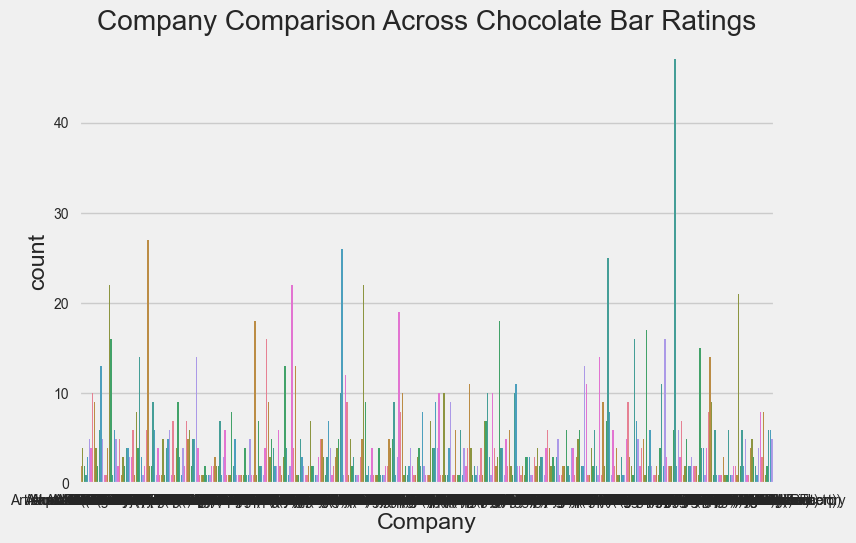

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (1039) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))


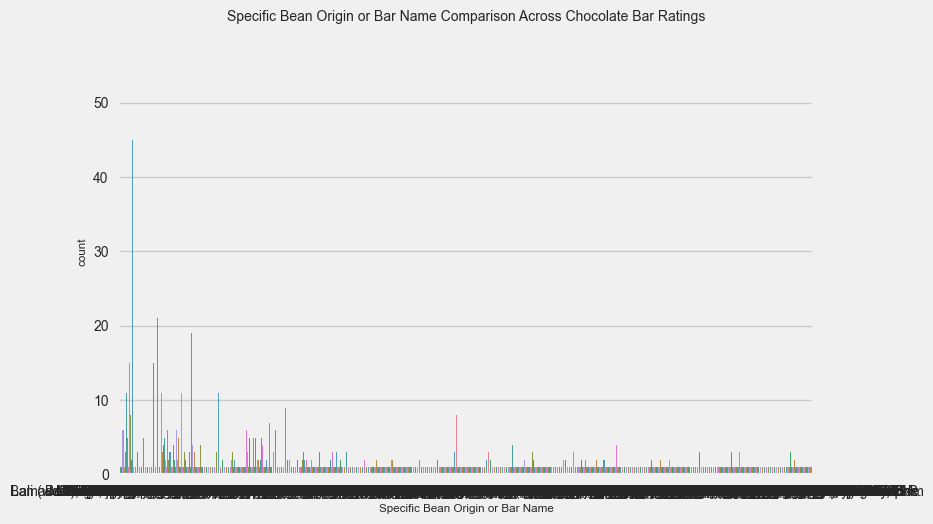

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (60) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))


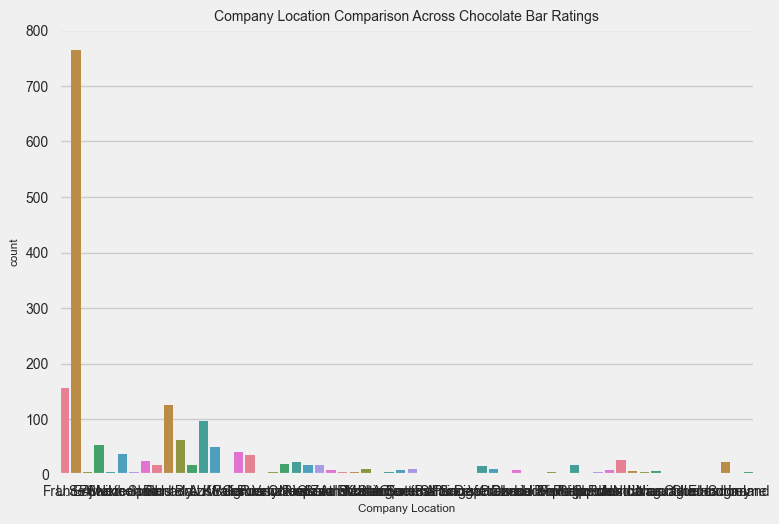

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (41) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))


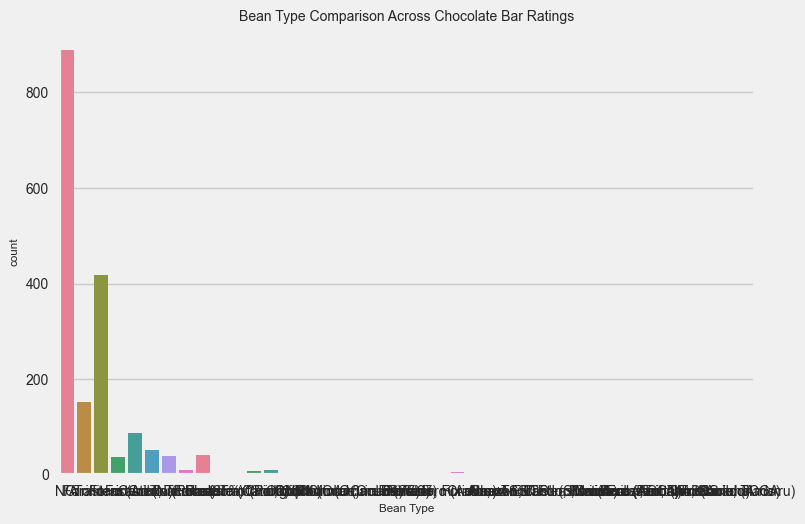

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))


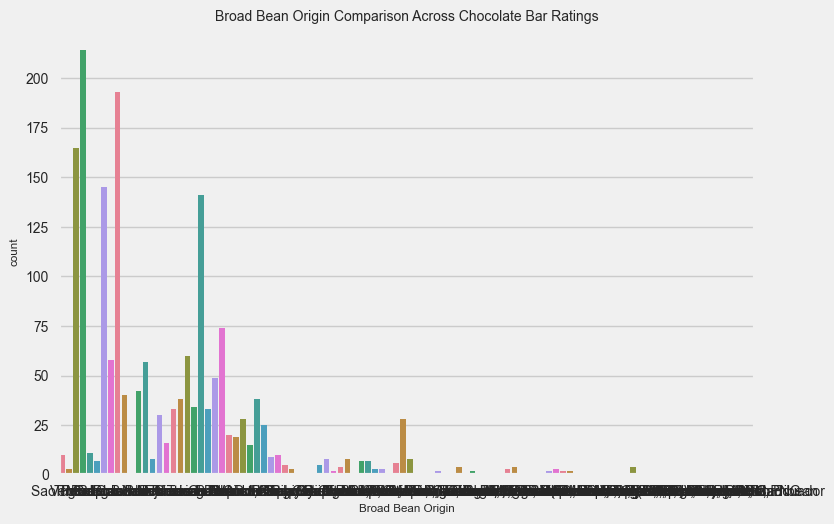

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\674198873.py:4: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))


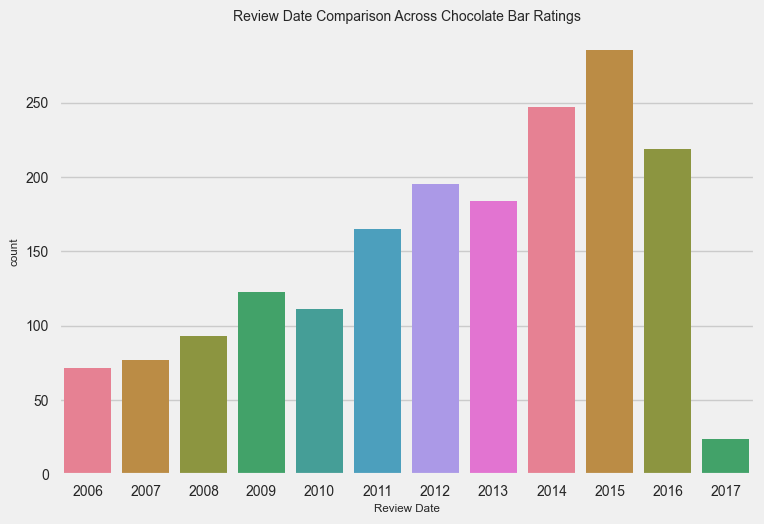

In [17]:
# Create bar graphs for descriptive statistics of the cars, figuring out how
# many fall into which group within each qualitative cateogry
def create_bar_graphs(attribute: str):
    sns.countplot(x=attribute, data=df, palette=sns.color_palette("husl", 8))
    plt.title(f"{attribute} Comparison Across Chocolate Bar Ratings")
    plt.rcParams["font.size"] = 7
    plt.show()

categorical_columns = ["Company", "Specific Bean Origin or Bar Name", "Company Location", "Bean Type", "Broad Bean Origin", "Review Date"]

for col in categorical_columns:
    create_bar_graphs(col)

In [18]:
review_date_min_year_val = df["Review Date"].min()
df["Review Date"] = df["Review Date"].map(lambda x: x - review_date_min_year_val)
df["Review Date"].unique()

array([10,  9,  8,  7,  6,  5,  3,  4, 11,  2,  1,  0], dtype=int64)

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\3503189455.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df["Cocoa Percent"],


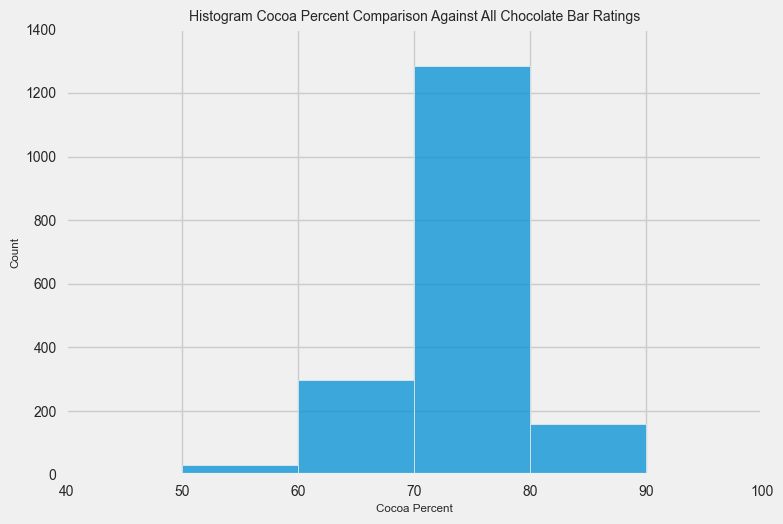

In [19]:
# Histogram plot illustrating the Cocoa Percent
bin_width = 10
df_cocoa_percent = df["Cocoa Percent"].round(0)
df_cocoa_percent = df_cocoa_percent.apply(int)
hist_low_range = (min(df_cocoa_percent) // 10) * 10
hist_high_range = (max(df_cocoa_percent) // 10) * 10

# # Set the style of seaborn
# sns.set(style="whitegrid")

sns.histplot(df["Cocoa Percent"], 
            bins=range(hist_low_range, hist_high_range, bin_width),
            kde=False,
            palette=sns.color_palette("husl", 8))
plt.rcParams["font.size"] = 7
plt.title("Histogram Cocoa Percent Comparison Against All Chocolate Bar Ratings")
plt.xlim(40, 100)
plt.ylim(0, 1400)
plt.show()

In [20]:
# Convert any needed categorical columns into numerical ones via factorizing (integer mapping)
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.factorize(df[col])[0]

In [21]:
df

,Company,Specific Bean Origin or Bar Name,Reference Number,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,0,0,1876,10,63.0,0,3.75,0,0
1,0,1,1676,9,70.0,0,2.75,0,1
2,0,2,1676,9,70.0,0,3.00,0,1
3,0,3,1680,9,70.0,0,3.50,0,1
4,0,4,1704,9,70.0,0,3.50,0,2
...,...,...,...,...,...,...,...,...,...
1790,415,21,647,5,70.0,48,3.75,0,2
1791,415,100,749,5,65.0,48,3.00,4,31
1792,415,1037,749,5,65.0,48,3.50,4,57
1793,415,1037,781,5,62.0,48,3.25,0,57


In [22]:
# Removed unnecessary columns not needed for heatmap comparison
df = df.drop(["Reference Number"], axis=1)
df

,Company,Specific Bean Origin or Bar Name,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,0,0,10,63.0,0,3.75,0,0
1,0,1,9,70.0,0,2.75,0,1
2,0,2,9,70.0,0,3.00,0,1
3,0,3,9,70.0,0,3.50,0,1
4,0,4,9,70.0,0,3.50,0,2
...,...,...,...,...,...,...,...,...
1790,415,21,5,70.0,48,3.75,0,2
1791,415,100,5,65.0,48,3.00,4,31
1792,415,1037,5,65.0,48,3.50,4,57
1793,415,1037,5,62.0,48,3.25,0,57


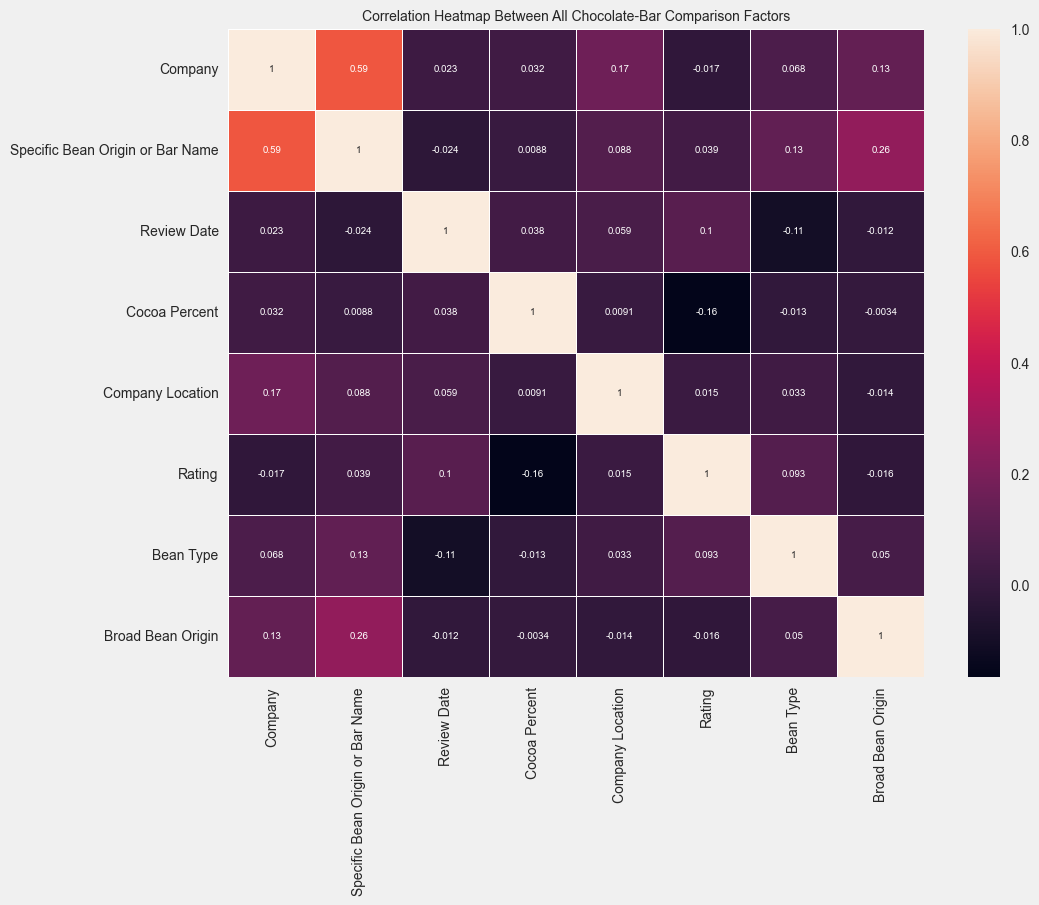

C:\Users\andre\AppData\Local\Temp\ipykernel_21852\3963744686.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))
C:\Users\andre\AppData\Local\Temp\ipykernel_21852\3963744686.py:14: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))


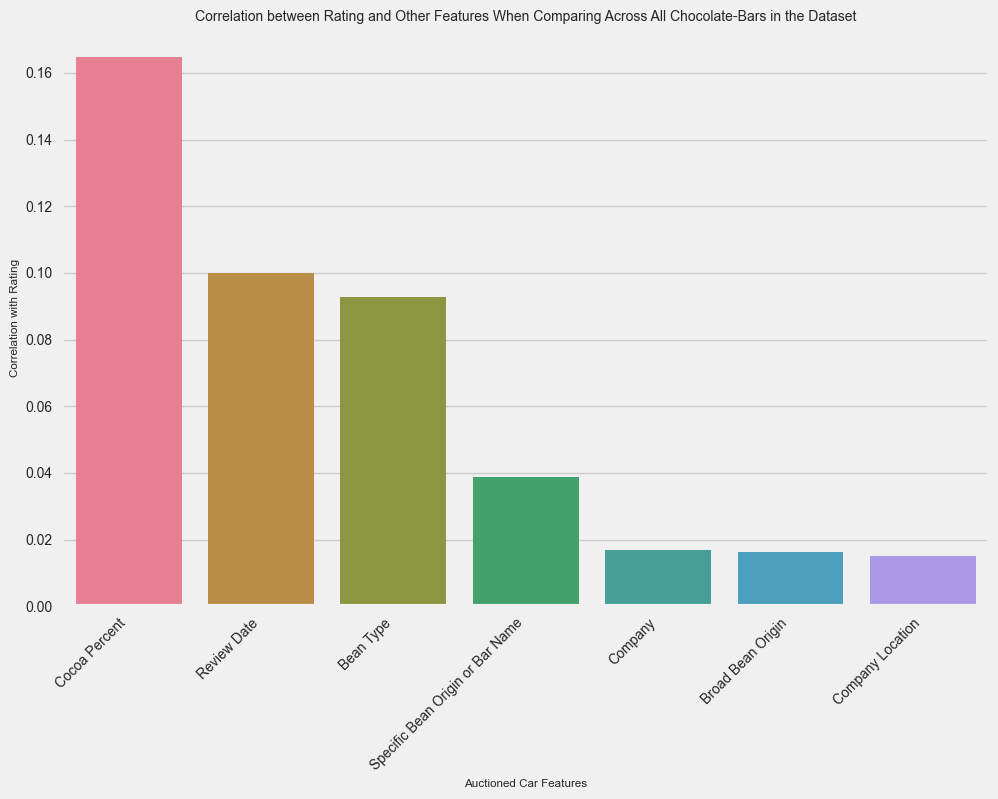

In [23]:
# Correlation heatmap to quantify relationships between chocolate-bar comparison
# attributes
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.heatmap(df.corr(), annot=True, linewidths=0.5)
plt.title("Correlation Heatmap Between All Chocolate-Bar Comparison Factors")
plt.show()

# Correlation bar graph between Rating and all other chocolate-bar comparison
# attributes
target_corr = df.corr()["Rating"].abs().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette=sns.color_palette("husl", 8))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Auctioned Car Features")
plt.ylabel("Correlation with Rating")
plt.title("Correlation between Rating and Other Features When Comparing Across All Chocolate-Bars in the Dataset")
plt.tight_layout()
plt.show()

In [24]:
# Removed unnecessary columns not needed for Machine Learning analysis
df = df.drop(columns=["Company", "Broad Bean Origin", "Company Location", "Specific Bean Origin or Bar Name"], axis=1)
df

,Review Date,Cocoa Percent,Rating,Bean Type
0,10,63.0,3.75,0
1,9,70.0,2.75,0
2,9,70.0,3.00,0
3,9,70.0,3.50,0
4,9,70.0,3.50,0
...,...,...,...,...
1790,5,70.0,3.75,0
1791,5,65.0,3.00,4
1792,5,65.0,3.50,4
1793,5,62.0,3.25,0


## Machine Learning - Model Training and Evaluation

Great, now we are onto the Machine Learning part of the blog post!

Since the dataframe is now properly cleaned, sorted, and integer-mapped by this point, I had split the respective dataframe into the train and test datasets for the Machine Learning model with 80% going to the training dataset and the last 20% going to the test dataset. Fortunately, because order of the data sequentially does not matter here, I was able to utilize the `train_test_split` function for shuffling and randomization, making the future-generated Machine Learning model more unpredictable but also more objective in its returned model results. 

Note that here I also used a `Pipeline` object from the `scikit-learn` package as well as the `StandardScaler` classes. On one hand, the `MinMaxScaler` class is useful for scaling columns to a specific range, usually between [0, 1], to maintain consistency. On the other hand, the `StandardScaler` class is useful for apply Z-score normalization / transformation on the data to avoid sensivite-prone Machine Learning algorithms which require appropriate scaling of the features within its trained dataset. As I learned from online, this `Pipeline` object is necesary to ensure appropriate preprocessing just before the dataset is passed to the Machine Learning model for training and later evaluation.  

In [25]:
X = df.drop(columns=["Rating"], axis=1)
y = df["Rating"]

print("X Shape:", X.shape)
print("Y Shape:", y.shape)

pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

X_scaled = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)

X Shape: (1795, 3)
Y Shape: (1795,)


Due to the higher-order dimensionality in the `X` columns, I had to utilze `PCA` to reduce the `X` columns in the dataset down to a manageable amount for humans (most accepted is `2` principal components).

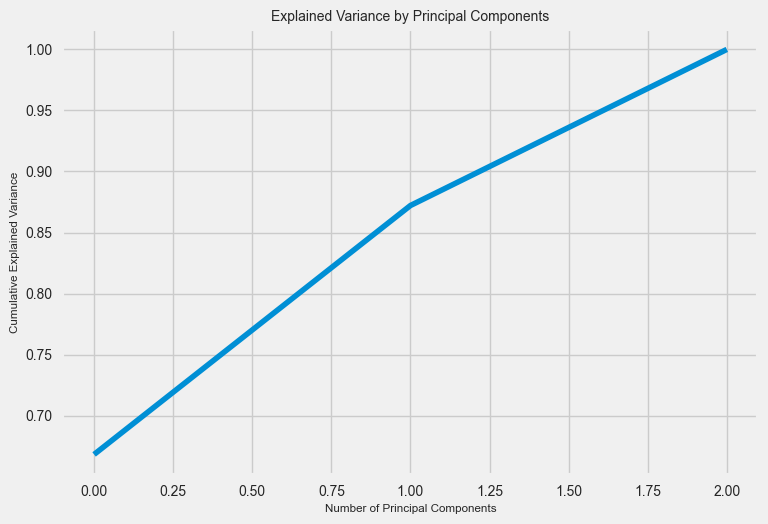

In [26]:
# Used PCA to lower the dimensionality of the dataset used later for Machine
# Learning (training and testing)
pca = PCA()
principal_components = pca.fit_transform(X_test)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [27]:
# Created a new dataframe containing the 2 main principal components used in the
# later Machine Learning section of this blog-post
pca_df = pd.DataFrame(data=principal_components[:, :2], columns=["PC1", "PC2"])
pca_df

,PC1,PC2
0,0.303283,-0.053220
1,0.032318,-0.015645
2,-0.152118,-0.054858
3,-0.242767,-0.047512
4,-0.152118,-0.054858
...,...,...
354,0.573557,-0.104226
355,-0.333623,-0.044195
356,-0.240286,-0.006366
357,-0.234078,0.100101


In [28]:
y_test.value_counts()

Rating
3.50    76
3.25    70
3.00    69
2.75    50
3.75    38
2.50    24
4.00    16
2.00     6
2.25     5
1.50     3
1.00     1
5.00     1
Name: count, dtype: int64

Adding in the `y` column (`"Rating"`) to this modified dataframe containing two new `PCA` components, we are able to experimentally look at some basic labeling of the data prior to clustering. 

*(Disclaimer: I realize that clustering is considered unsupervised Machine Learning. The experimental practices of labels here are merely for reference to anticipate future clustering patterns. In real clustering applications, I realize that I wouldn't really have the labels to cluster in the first place. As seen throughout this section, this practice doesn't intend to skew my Machine Learning methods.)*

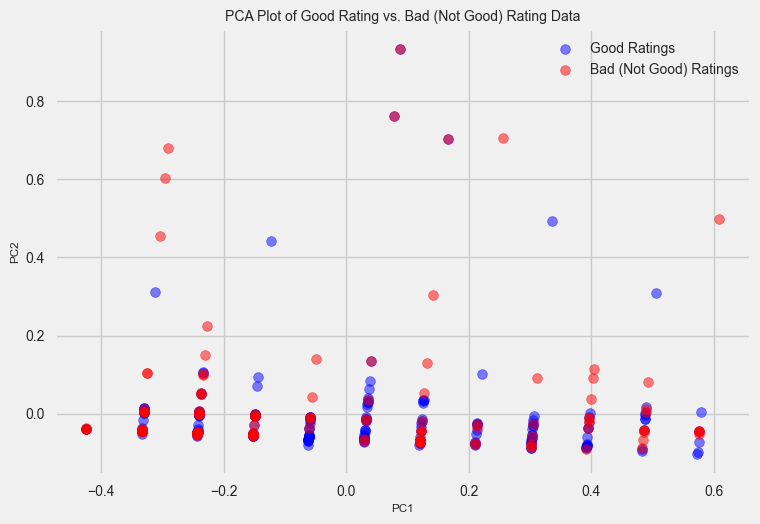

In [29]:
# Add the "Rating" column to the PCA DataFrame
pca_df["Rating"] = y_test.values

# Separate the data based on the "Rating" columns (my subjective cut-off on 
# numerical ratings to label "good" vs. "bad" ratings - out of 5)
good_ratings = pca_df[pca_df["Rating"] >= 3.5]
not_good_ratings = pca_df[pca_df["Rating"] < 3.5]

# Scatter plot with different colors for "Good" and "Bad"
plt.scatter(not_good_ratings["PC1"], not_good_ratings["PC2"], c='blue', label='Good Ratings', alpha=0.5)
plt.scatter(good_ratings["PC1"], good_ratings["PC2"], c='red', label='Bad (Not Good) Ratings', alpha=0.5)

plt.title("PCA Plot of Good Rating vs. Bad (Not Good) Rating Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [30]:
# Match PCA dataframe with y_test data with "binary" classification of chocolate-bar
# ratings
y_test = y_test.map(lambda entry: 0 if entry < 3.5 else 1)
y_test

1234    0
220     1
1516    1
438     1
1268    0
       ..
1114    0
1729    0
1615    0
1036    1
964     0
Name: Rating, Length: 359, dtype: int64

Now, we will do an exploratory K-Means Clustering to see if we detect any patterns or correlations in the dataset between `Rating` and other categories that were reported with the existing chocolate-bar evaluations.

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

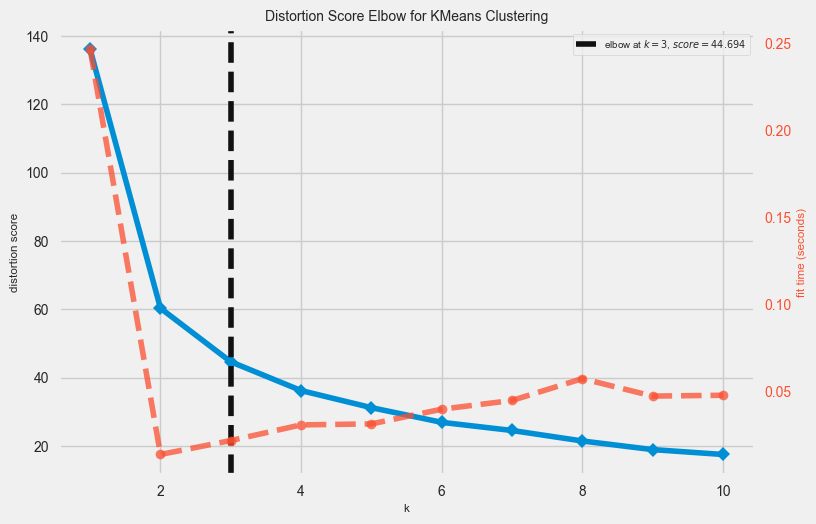

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# Using the KElbowVisualizer to determine the appropriate number of clusters
# to use in the K-Means algorithm
kmeans_model = KMeans()
kmeans_elbow_visualizer = KElbowVisualizer(kmeans_model, k=(1, 11))
kmeans_elbow_visualizer.fit(X_train)
kmeans_elbow_visualizer.show()

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


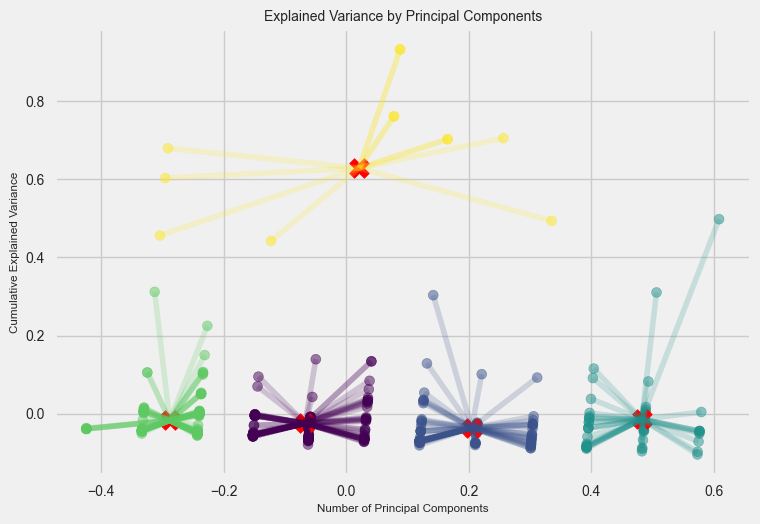

In [32]:
# Complete K-Means Clustering to find any clustering relationships in dataset
# Run the kmeans model on scaled data
kmeans_model = KMeans(n_clusters=5, random_state=42).fit(X_train)

# Get the cluster number for each datapoint
X_clusters = kmeans_model.predict(X_test)

# Save the cluster centroids
X_clusters_centers = kmeans_model.cluster_centers_

# Plot PCA and K-Means cluster centers
X_test_principal_clusters_centers = pca.transform(X_clusters_centers)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=X_clusters, cmap='viridis', s=50, alpha=0.5)
plt.scatter(X_test_principal_clusters_centers[:, 0], X_test_principal_clusters_centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# Set up a LineCollection (for creating lines from each data point to their 
# respective cluster center)
lines = [[(x1, y1), (x2, y2)] for x1, y1, x2, y2 in zip(principal_components[:, 0], principal_components[:, 1], X_test_principal_clusters_centers[X_clusters][:, 0], X_test_principal_clusters_centers[X_clusters][:, 1])]
lc = LineCollection(lines, cmap='viridis', norm=plt.Normalize(vmin=np.min(X_clusters), vmax=np.max(X_clusters)), alpha=0.2)

# Set the color values based on the distance from the cluster center
lc.set_array(np.array(X_clusters))

# Add the created LineCollection to the plot
plt.gca().add_collection(lc)

plt.title("Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [33]:
# Obtain predictions and calculate distance from cluster centroid (using Euclidean Distance)
kmeans_dist = [np.linalg.norm(x - y) for x, y in zip(principal_components, X_test_principal_clusters_centers[X_clusters])]

y_pred = np.array(kmeans_dist)
y_pred[kmeans_dist >= np.percentile(kmeans_dist, 95)] = 1
y_pred[kmeans_dist < np.percentile(kmeans_dist, 95)] = 0
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

ROC AUC Score: 50.04%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.635294    0.368421   0.62117    0.501858      0.537911
recall       0.947368    0.053435   0.62117    0.500402      0.621170
f1-score     0.760563    0.093333   0.62117    0.426948      0.517089
support    228.000000  131.000000   0.62117  359.000000    359.000000
_______________________________________________
Confusion Matrix:
[[216  12]
 [124   7]]


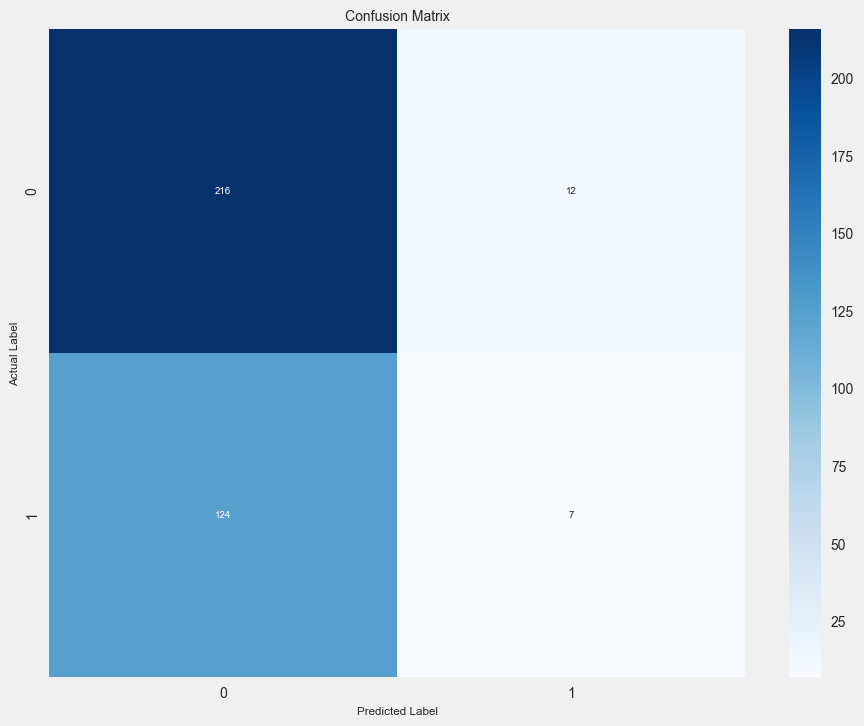

In [34]:
# Display the accuracy statistics and the confusion matrix of the K-Means algorithm 
# cluster predictions
clf_report = pd.DataFrame(classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, zero_division=0))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(f"ROC AUC Score: {roc_auc_score(y_true=y_test, y_score=y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

Finally, in addition to the K-Means clustering, for each entry in the (PCA) dataset, I have computed the distance to its closest cluster center and provided its respective closest cluster-index in a provided dataframe below, leaving this as an exercise to the reader to further explore any potential relationships that may be present here in the evalation scores. 

In [35]:
# Calculates distances from mean and group similar-distances (print table)
df_kmeans_cluster_info = pd.DataFrame(data={"PC1": principal_components[:, 0], 'PC2': principal_components[:, 1]})

# Find the index of the closest cluster center for each point
closest_cluster_index = [np.argmin(np.linalg.norm(principal_components[i] - X_clusters_centers, axis=1)) for i in range(len(principal_components))]

# Add the closest cluster center number and Euclidean distance to the DataFrame
df_kmeans_cluster_info["Distance_to_Closest_Cluster"] = [np.linalg.norm(principal_components[i] - X_clusters_centers[X_clusters[i]]) for i in range(len(principal_components))]
df_kmeans_cluster_info["Closest_Cluster"] = X_clusters[closest_cluster_index]
df_kmeans_cluster_info

,PC1,PC2,Distance_to_Closest_Cluster,Closest_Cluster
0,0.303283,-0.053220,0.558196,0
1,0.032318,-0.015645,0.814719,0
2,-0.152118,-0.054858,0.983476,0
3,-0.242767,-0.047512,1.244446,0
4,-0.152118,-0.054858,0.983476,0
...,...,...,...,...
354,0.573557,-0.104226,0.794724,0
355,-0.333623,-0.044195,1.323382,0
356,-0.240286,-0.006366,1.234437,0
357,-0.234078,0.100101,1.175465,0


## Conclusions

- Given that `(K-Means) Clustering` is considered as `Unsupervised Machine Learning`, I found that the 3 kept columns from the original dataset - `Cocoa Percent`, `Review Date`, and `Bean Type` - were excellent in providing insights about the factors that went into the final determination of the `Rating` of the overall set of chocolate-bar entries. Looking at the dataset more closely, chocolate bars that had a similar numerical percentages of chocolate in its composition, similar dates of review, and similar-tasting chocolate bean types seemingly were grouped in the same cluster. This is something I expected going into this blog-post because this seems reasonable. However, from basic observation, no one factor dominated the other as I could find any leading trends in the K-Means clustering completed above. 

- In terms of expanding the scope of this blog-post, I would have taken this further by viewing chocolate-bar entries that are similar in the distance from the same cluster center must be "numerically" similar and perform further Machine Learning analyses into determining the factors that lead to them receiving that particular score among the consensus of chocolate-bar evaluators.

- Ultimately, I learned a great deal from the blog post experience as I now better understand how to properly utilize `K-Means Classifiers`, an unsupervised classification method of Machine Learning, to find relationships between groups of data and infer conclusions about any potential trends, through applying it to a practical, every-day dilemma in our society. Even though the datasets in the real world are never this simple to analyze, I hope to utilize in future contexts as this was an interesting study to complete and creative question to answer. This does seem like a sub-field and problem space that I may try to pursue in the future. 

## Reference Sources and Citations (IEEE Format)

To complete this blog post, I used the following online sources as references for developing this:

[1] Chocolate Car Ratings Dataset:

- R. Tatman, "Chocolate Bar Ratings", 2017. [Online]. Available: https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings/data. [Accessed 15-Nov.-2023].

[2] KMeans Elbow Reference: 

- F. Javier Gallego, "Outliers+EDA+Clustering Tutorial", Jul.-2022. [Online]. Available: https://www.kaggle.com/code/javigallego/outliers-eda-clustering-tutorial. [Accessed 16-Nov.-2023].

[3] KMeans Reference:

- M. Isbaine, "Fraud Detection", 2021. [Online]. Available: https://www.kaggle.com/code/mohamedisbaine/fraud-detection. [Accessed 16-Nov.-2023].